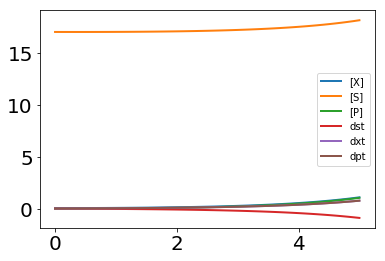

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)
from scipy.optimize import curve_fit

import tellurium as te
import roadrunner

def fermentationFeedBatchModel():
    mu_model = '''
    model *fermentationModel()
        compartment comp;
        comp = 1;
        #species
        species X,S,P
        
        S in comp ;  X in comp; P in comp;
        
        X_init = 0.05
        P_init = 0.0
        S_init = 17
        
        # Parameters
        init_mu_max = 0.5
        init_Ksx = 0.1
        init_Ksp = 0.1
        init_qs_max = 0.5
        init_Gs = 0.4
        init_Ms = 0.1
        init_Yx = 11.0
        init_Yp = 11.0
        
        X = X_init
        P = P_init
        S = S_init
        
        mu_max = init_mu_max
        Ksx = init_Ksx
        Ksp = init_Ksp
        qs_max = init_qs_max
        Gs = init_Gs
        Ms = init_Ms
        Yx = init_Yx
        Yp = init_Yp
        
        mu := (mu_max * S)/(Ksx + S)
        qp := (qs_max * S)/(Ksp + S)
           
        dxdt : = mu * X;
        dpdt := qp * X;
        dsdt := ((-1/Yx) * mu - (1/Yp) * qp - Gs - Ms) * X
        
        dst = 0.01
        dxt = 0.01
        dpt = 0.01
        
        dst' = dsdt
        dxt' = dxdt
        dpt' = dpdt
        
        # mass balances
        EqS: S ->  ; dst
        EqX: -> X ; dxt
        EqP: -> P ; dpt
    end
    '''
    r=te.loada(mu_model)
    return r

r =fermentationFeedBatchModel()
#print(r.getCurrentAntimony())
r.simulate()
r.plot()

In [209]:
texp= [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 55, 60, 65]
Xexp= [0.05, 0.1, 0.2, 0.6, 0.7, 0.75, 0.8, 0.8, 0.8, 0.85, 0.9, 0.9, 0.9, 0.92, 0.93, 0.94, 0.95]
Pexp= [0.0, 1, 1.8, 2.1, 3, 3.8, 4.2,4.8, 5, 5.4, 5.9, 6.5, 7, 7.4, 7.7, 7.9, 8]
Sexp= [17, 16.5, 15.5, 14.2, 13, 11.5, 10, 9, 8, 7.4, 6.2, 5.8, 5, 4.8, 4.2, 3.8, 3.4]

In [210]:
## solving all the differential equations

def f(x,s,t,mu_max,ksx):
    dxdt = ((mu_max * s)/(ksx + s)) * x
    return dxdt

def fp(x,s,t,qp_max,ksp):
    dpdt = ((qp_max * s)/(ksp + s)) * x
    return dpdt

def fs(x,s,t,mu_max,qp_max,yx,yp,ms,gs,ksx,ksp):
    dsdt = (-1/yx * ((mu_max * s)/(ksx + s)) - 1/yp*((qp_max * s)/(ksp + s)) - gs - ms) * x
    return dsdt


In [301]:
from scipy.integrate import odeint
%matplotlib inline

mu_max = np.linspace(0,1,17)
mu_max = np.asarray(mu_max)

qp_max = np.linspace(0,1,17)
qp_max = np.asarray(qp_max)

Ksx = np.linspace(1,5,17)
ksx = np.asarray(Ksx)

Ksp = np.linspace(1,5,17)
ksp = np.asarray(Ksp)

yx =np.linspace(1,20,17)
yx = np.asarray(yx)

yp = np.linspace(1,20,17)
yp = np.asarray(yp)

gs = np.linspace(0,1,17)
ms = np.linspace(0,1,17)

x = odeint(f,Xexp,texp,args=(Sexp,mu_max,ksx))
p = odeint(fp,Pexp,texp,args=(Sexp,qp_max,ksp))
s = odeint(fs,Sexp,texp,args=(Xexp,mu_max,qp_max,yx,yp,ms,gs,ksx,ksp))

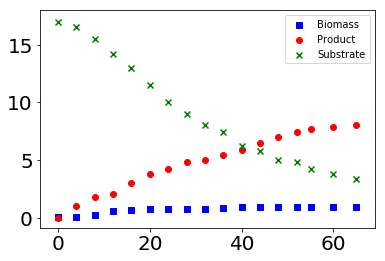

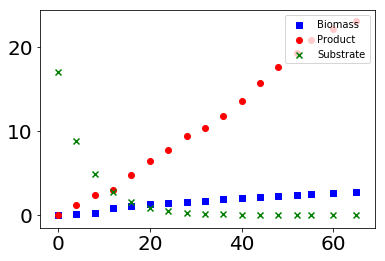

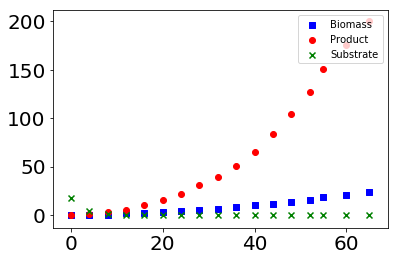

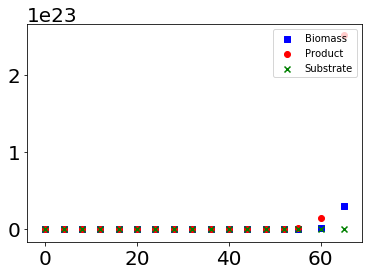

In [302]:
texp =np.asarray(texp)

plt.scatter(texp,x[0,:],c='b', marker='s',label ='Biomass') 
plt.scatter(texp,p[0,:],c='r', marker='o',label ='Product') 
plt.scatter(texp,s[0,:],c='g', marker='x',label ='Substrate')
plt.legend(loc ='upper right')
plt.savefig("Solved ODEs Plot 1: Initial state variables of the reactor")
plt.show()

plt.scatter(texp,x[1,:],c='b', marker='s',label ='Biomass') 
plt.scatter(texp,p[1,:],c='r', marker='o',label ='Product') 
plt.scatter(texp,s[1,:],c='g', marker='x',label ='Substrate')
plt.legend(loc ='upper right')
plt.savefig("Solved ODEs Plot 2: Second simulated model state variables for the reactor")
plt.show()

plt.scatter(texp,x[2,:],c='b', marker='s',label ='Biomass') 
plt.scatter(texp,p[2,:],c='r', marker='o',label ='Product') 
plt.scatter(texp,s[2,:],c='g', marker='x',label ='Substrate')
plt.legend(loc ='upper right')
plt.savefig("Solved ODEs Plot 3: Third simulated model state variables for the reactor")
plt.show()


plt.scatter(texp,x[16,:],c='b', marker='s',label ='Biomass') 
plt.scatter(texp,p[16,:],c='r', marker='o',label ='Product') 
plt.scatter(texp,s[16,:],c='g', marker='x',label ='Substrate')
plt.legend(loc ='upper right')
plt.savefig("Solved ODEs Plot 16: 17th simulated model state variables for the reactor")
plt.show()

In [314]:
# puttting it all together
X = np.vstack((mu_max,qp_max,ksx,ksp,yx,yp,gs,ms))
df = pd.DataFrame(X.T)
df.columns = ['mu_max','qp_max','ksx','ksp','yx','yp','gs','ms']
df.to_csv("Estimated_Parameters.csv")



In [298]:
mu_max = np.linspace(0,1,17)
mu_max = np.asarray(mu_max)

qp_max = np.linspace(0,1,17)
qp_max = np.asarray(qp_max)

Ksx = np.linspace(1,5,17)
ksx = np.asarray(Ksx)

Ksp = np.linspace(1,5,17)
ksp = np.asarray(Ksp)


mu = [ (ii[0]*ii[2][2])/(ii[1] + ii[2][2]) for ii in zip(mu_max,ksx,X)]
qp = [ (kk[0]*kk[2][2])/(kk[1] + kk[2][2]) for kk in zip(qp_max,ksp,X)]

In [299]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled =scaler.fit_transform(X)

mu = np.asarray(mu)
qp = np.asarray(qp)


X = X_scaled.reshape(17,17,3,1)


ys = mu
yp = qp

X_train, X_test, y_train, y_test = train_test_split(X, ys,test_size=0.33, random_state=42)

X_test.shape


(6, 17, 3, 1)

In [300]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten

model = Sequential()
model.add(Conv2D(3,(2,2),strides=(1,1),input_shape=(17,3,1),activation ='relu'))
model.add(Dense(6, kernel_initializer='normal',activation ='tanh'))
model.add(Flatten())
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10,validation_split =0.2,steps_per_epoch=10,validation_steps=5)

Train on 8 samples, validate on 3 samples
Epoch 1/10
10/10 [==============================] - 1s 74ms/step - loss: 4.6504e-04 - acc: 0.0000e+00 - val_loss: 2.6271e-04 - val_acc: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 3.7680e-04 - acc: 0.0000e+00 - val_loss: 2.4125e-04 - val_acc: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 3.2594e-04 - acc: 0.0000e+00 - val_loss: 2.0052e-04 - val_acc: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 2.7569e-04 - acc: 0.0000e+00 - val_loss: 1.7273e-04 - val_acc: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 2.2176e-04 - acc: 0.0000e+00 - val_loss: 1.4929e-04 - val_acc: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 1.6905e-04 - acc: 0.0000e+00 - val_loss: 1.3894e-04 - val_acc: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 1.2443e-0

In [293]:
preds = model.predict(X_test)



In [ ]:
import scipy
import scipy.stats

mu_max = 0.5
Ksx = 0.1

X = np.asarray([1/i for i in Sexp ])
Y = np.asarray([1/(mu_max*i/(i+Ksx)) for i in Sexp])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X,Y)

plt.figure(1,figsize=(13, 7))
plt.plot(X, Y, 'o', label='original data')
plt.plot(X, intercept + slope *X, 'r', label='fitted line')
plt.ylabel('1/mu (g DW/L)', fontsize = 25)
plt.xlabel('1/s (hour)', fontsize = 25)
plt.title('1/s vs 1/mu and regression line',fontsize = 30, weight = 'bold')
plt.legend(fontsize = 25)

plt.savefig('fitted_model_invmu_vs_invsub.pdf')

plt.show()

#intercept = 1/mu_max => mu_max = 1/intercept
mu_max = 1/intercept
# slope = ksx/mu_max
ksx = slope * mu_max

print(mu_max)
print(ksx)

In [ ]:
import scipy
import scipy.stats


y = np.asarray(Xexp)
x= np.asarray(texp)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

plt.figure(1,figsize=(13, 7))
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope *x, 'r', label='fitted line')
plt.ylabel('Biomass (g DW/L)', fontsize = 25)
plt.xlabel('Time (hour)', fontsize = 25)
plt.title('X vs time and regression line',fontsize = 30, weight = 'bold')
plt.legend(fontsize = 25)

plt.savefig('fitted_model_biomass.pdf')

plt.show()

In [ ]:
yp = np.asarray(Pexp)
x= np.asarray(texp)
sp, p_intercept, r_value, p_value, std_err = scipy.stats.linregress(x,yp)

plt.figure(1,figsize=(13, 7))
plt.plot(x, yp, 'o', label='original data')
plt.plot(x, p_intercept + sp *x, 'r', label='fitted line')
plt.ylabel('Product (g DW/L))', fontsize = 25)
plt.xlabel('Time (hour)', fontsize = 25)
plt.title('P vs time and regression line',fontsize = 30, weight = 'bold')
plt.legend(fontsize = 25)

plt.savefig('fitted_model_product.pdf')

plt.show()


In [ ]:
ys = np.asarray(Sexp)
x= np.asarray(texp)
ss, s_intercept, r_value, p_value, std_err = scipy.stats.linregress(x,ys)

plt.figure(1,figsize=(13, 7))
plt.plot(x, ys, 'o', label='original data')
plt.plot(x, s_intercept + ss *x, 'r', label='fitted line')
plt.ylabel('Substrate (g DW/L))', fontsize = 25)
plt.xlabel('Time (hour)', fontsize = 25)
plt.title('S vs time and regression line',fontsize = 30, weight = 'bold')
plt.legend(fontsize = 25)

plt.savefig('fitted_model_sub.pdf')

plt.show()

In [ ]:
qs_max = 0.5
Ksp = 0.1

Ksp = np.linspace()

X = np.asarray([1/i for i in Sexp ])
qp = np.asarray([1/(qs_max*i/(i+Ksp)) for i in Sexp])

def f(x, a, b):
    return a*x + b

p, pcov = curve_fit(f, X, qp)

# The diagonals in covariance is the variance of the parameter estimation. 
# Then we can compute the standard deviation on the parameters with ->
perr = np.sqrt(np.diag(pcov))

xi = np.linspace(np.min(X), np.max(X), 100)
ps = np.random.multivariate_normal(p, pcov, 10000)

# This creates (10000,100) array i.e. 100 y samples pr. set of slope and intercept sample, so 100 samples 10000 times. 
# In percentile axis 0 means it takes the values in the column, order it from lowest to highest then multiply 0.025*10.000 test scores for the lower confidence interval. 
ysample = np.asarray([f(xi, *pi) for pi in ps])
lower = np.percentile(ysample, 2.5, axis=0)
upper = np.percentile(ysample, 97.5, axis=0)

plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X, qp, 'bo')
plt.plot(X, p[1] + p[0]*X, 'r-')
plt.plot(xi, lower, 'b--')
plt.plot(xi, upper, 'b--')
plt.ylabel('1/$qp_{p}$',fontsize = 20)
plt.xlabel('1/$C_{s}$',fontsize = 20)
plt.title('1/$qp_{p}$ vs 1/$C_{s}$',fontsize = 25)
plt.savefig('invqp_vs_invsub.pdf')
plt.show()

# Calculates R^2 value
SSE = np.sum((qp - (p[1] + p[0]*X))**2)
SST = np.sum((qp - np.mean(qp))**2)
r_squared = 1 - (SSE/SST)
print(r_squared)
print(p[1])

In [ ]:
qp_max = 1/p[1] 
print(qp_max)

# The slope = Ks/qs_max =>  qs_max*slope = Ks
Ksp = qp_max*p[0] 
print(Ksp) 

In [ ]:
mu_max = 0.5
Ksx = 0.1


X = np.asarray([1/i for i in Sexp ])
Y = np.asarray([1/(mu_max*i/(i+Ksx)) for i in Sexp])

def f(x, a, b):
    return a*x + b

p, pcov = curve_fit(f, X, Y)

# The diagonals in covariance is the variance of the parameter estimation. 
# Then we can compute the standard deviation on the parameters with ->
perr = np.sqrt(np.diag(pcov))

xi = np.linspace(np.min(X), np.max(X), 100)
ps = np.random.multivariate_normal(p, pcov, 10000)

# This creates (10000,100) array i.e. 100 y samples pr. set of slope and intercept sample, so 100 samples 10000 times. 
# In percentile axis 0 means it takes the values in the column, order it from lowest to highest then multiply 0.025*10.000 test scores for the lower confidence interval. 
ysample = np.asarray([f(xi, *pi) for pi in ps])
lower = np.percentile(ysample, 2.5, axis=0)
upper = np.percentile(ysample, 97.5, axis=0)

plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X, Y, 'bo')
plt.plot(X, p[1] + p[0]*X, 'r-')
plt.plot(xi, lower, 'b--')
plt.plot(xi, upper, 'b--')
plt.ylabel('1/$mu_{x}$',fontsize = 20)
plt.xlabel('1/$C_{s}$',fontsize = 20)
plt.title('1/$mu_{x}$ vs 1/$C_{s}$',fontsize = 25)
plt.savefig('invmu_vs_invsub.pdf')
plt.show()

# Calculates R^2 value
SSE = np.sum((Y - (p[1] + p[0]*X))**2)
SST = np.sum((Y - np.mean(Y))**2)
r_squared = 1 - (SSE/SST)
print(r_squared)
print(p[1])

In [ ]:
mu_max = 1/p[1] 
print(mu_max)

# The slope = Ks/qs_max =>  qs_max*slope = Ks
Ksx = mu_max*p[0] 
print(Ksx) 

In [ ]:
mu_max  = 0.5
Ksx = 0.1

def func(x):
    return  (mu_max*x/(x+Ksx))

xi = np.linspace(np.min(Sexp), np.max(Sexp), 100)
plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(Sexp, 1/Y, 'bo')
plt.plot(xi, func(xi), 'r-')
plt.ylabel('$mu_{x}$ $(g_{sub}/(g_{bio}*h))$',fontsize = 20)
plt.xlabel('Initial substrate concentration $C_{s}$ g/L',fontsize = 20)
plt.title('$mu_{x}$ vs $C_{s}$',fontsize = 25)
plt.savefig('mu_vs_sub_model.pdf')
plt.show()

In [ ]:
data = np.vstack([texp, Xexp,Pexp,Sexp])

plt.scatter(data[0,:],data[1,:],c='b', marker='s', label='Biomass')
#plt.plot(data[0,:],data[1,:])
plt.scatter(data[0,:],data[2,:],c='r', marker='o', label='Product')
#plt.plot(data[0,:],data[2,:])
plt.scatter(data[0,:],data[3,:],c='g',marker ='x',label ='Substrate')
#plt.plot(data[0,:],data[3,:])
plt.legend(loc ='upper right')
plt.savefig("Scatter Plots")
plt.show()

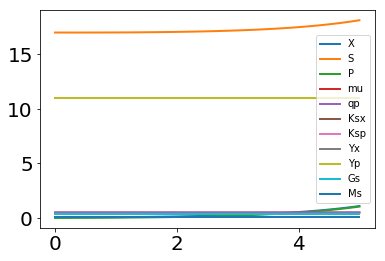

In [111]:
reactor =fermentationFeedBatchModel()
reactor.reset()
reactor.time = texp
reactor.X_init = float(Xexp[0])
reactor.S_init = float(Sexp[0])
reactor.P_init = float(Pexp[0])


reactor.timeCourseSelections = ['time', 'X','S', 'P','mu','qp','Ksx','Ksp','Yx','Yp','Gs','Ms']
#reactor.timeCourseSelections = ['mu','S']
reactor.simulate()

#plt.scatter(results[:,0],results[:,2],c='b', marker='s', label='Biomass')
#plt.plot(results[:,0],results[:,2])
#plt.scatter(results[:,0],results[:,3],c='r', marker='o', label='Product')
#plt.plot(results[:,0],results[:,3])
#plt.scatter(results[:,0],results[:,2],c='g',marker ='x',label ='Substrate')
#plt.plot(results[:,0],results[:,2])
#plt.legend(loc ='upper left')
#plt.savefig("Distribution plots")
reactor.plot()

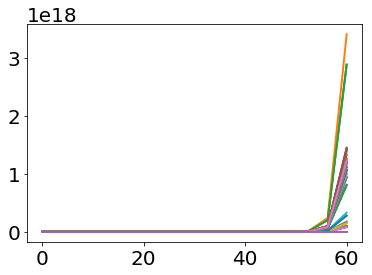

In [112]:
results = reactor.simulate(0, 60, 17)

for t,x,p,s in zip(texp,Xexp,Pexp,Sexp):
    reactor.reset()
    reactor.time = t
    reactor.X_init = x
    reactor.S_init = s
    reactor.P_init = p
    reactor.timeCourseSelections =  ['time', 'X','S', 'P','mu','qp','Ksx','Ksp','Yx','Yp','Gs','Ms']
    #reactor.timeCourseSelections = ['mu','S']
    results = np.hstack([results,reactor.simulate(0, 60,17)])
    df = pd.DataFrame(results)
    #df.columns =  ['time', 'X','S', 'P','mu','qp','Ksx','Ksp','Yx','Yp','Gs','Ms']
    #df.columns =['mu','S']
    df.to_csv("Results.csv")
    

te.plotArray(results)